In [2]:
from typing import (Tuple,List,Callable,Union,Dict)

import pandas as pd
import numpy as np
import empyrical as ep
from collections import (defaultdict,namedtuple)
from jqdata import *


import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  #用来正常显示负号

In [3]:
# 标准化趋势
class Normalize_Trend(object):
    
    '''
    标准化价格位移
    
    注意:位移向量比状态变化向量多一个初始单元0
    '''
    
    def __init__(self,close_ser: pd.Series) -> None:

        if not isinstance(close_ser, pd.Series):

            raise ValueError('输入参数类型必须为pd.Series')

        self.close_ser = close_ser

    def normalize_monotone(self) -> pd.Series:
        '''单调性标准化'''

        sign = self.close_ser.pct_change().apply(np.sign)
        sign = sign.cumsum().fillna(0)

        return sign

    def normalize_movingaverage(self, window: int = 5) -> pd.Series:
        '''5周期均线的标准化'''

        close_ser = self.close_ser
        size = len(close_ser)

        if size < window:

            raise ValueError('输入数据长度小于窗口期')

        ma = close_ser.rolling(window).mean()
        sign = (close_ser - ma).apply(np.sign).iloc[window - 2:]
        sign = sign.cumsum().fillna(0)

        return sign

    def normalize_compound(self, window: int = 5):

        close_ser = self.close_ser

        size = len(close_ser)

        if size < window:

            raise ValueError('输入数据长度小于窗口期')

        ma = close_ser.rolling(window).mean()

        previous_price = close_ser.shift(1)

        cond1 = (previous_price - ma < 0) & (close_ser - ma > 0)
        cond2 = (previous_price - ma > 0) & (close_ser - ma < 0)

        cond1 = cond1 * 1
        cond2 = cond2 * -1

        cond3_a = (previous_price - ma >
                   0) & (close_ser - ma > 0) & (close_ser > previous_price)

        cond3_b = (previous_price - ma >
                   0) & (close_ser - ma > 0) & (close_ser < previous_price)

        cond4_a = (previous_price - ma <
                   0) & (close_ser - ma < 0) & (close_ser > previous_price)

        cond4_b = (previous_price - ma <
                   0) & (close_ser - ma < 0) & (close_ser < previous_price)

        cond3_a = cond3_a * 1
        cond3_b = cond3_b * 0
        cond4_a = cond4_a * 0
        cond4_b = cond4_b * -1

        sign = cond1 + cond2 + cond3_a + cond3_b + cond4_a + cond4_b
   
        sign = sign.iloc[window - 2:].cumsum().fillna(0)
     
        return sign

class Tren_Score(object):
    '''
    根据标准化后的价格数据计算趋势得分
    ------
    输入参数：
        normalize_trend_ser:pd.Series index-date values-标准化后的价格数据

    方法：
        评分方法均有两种计算模式区别是划分波段的方法不同
        分别是opposite/absolute 即【相对波段划分】和【绝对波段划分】

        calc_trend_score:计算“趋势”得分
            score Dict
                - trend_score 势得分
                - act_score 趋得分
            - point_frame Dict 标记表格
            - point_mask Dict 标记点
        calc_absolute_score:计算混合模式得分
    '''
    def __init__(self, normalize_trend_ser: pd.Series) -> None:

        if not isinstance(normalize_trend_ser, pd.Series):

            raise ValueError('输入参数类型必须为pd.Series')

        self.normalize_trend_ser = normalize_trend_ser

        # 储存标记点表格
        self.point_frame:Dict[pd.DataFrame] = defaultdict(pd.DataFrame)
        self.score_record = namedtuple('ScoreRecord','trend_score,act_score')
        self.score:Dict = defaultdict(namedtuple)

        # 储存标记点标记
        self.point_mask:Dict[List] =  defaultdict(list)

        self.func_dic: Dict = {
            'opposite': self._get_opposite_piont,
            'absolute': self._get_absolute_point
        }

    def calc_trend_score(self, method: str) -> float:
        '''势'''

        func: Callable = self.func_dic[method]

        # 趋势极值点得标记
        cond:pd.Series = func()

        # 势得分
        trend_score = np.square(self.normalize_trend_ser[cond].diff()).sum()
        # 趋得分
        act_score = self.normalize_trend_ser.diff().sum()

        self.score[method] = self.score_record(trend_score=trend_score,
                                               act_score=act_score)
        
        self.point_frame[method] = self.normalize_trend_ser[cond]

        self.point_mask[method] = cond

    def calc_absolute_score(self) -> float:

        '''势的终极定义'''

        opposite = self.calc_trend_score('opposite')
        absolute = self.calc_trend_score('absolute')

        N = len(self.normalize_trend_ser)

        return max(opposite, absolute) / (N * (3 / 2))

    def _get_opposite_piont(self) -> List:
        '''
        获取相对拐点的位置
        ------
        return np.array([True,..False,...True])
            True表示为拐点，False表示不是
        '''
        ser = self.normalize_trend_ser
        flag_ser = pd.Series(index=ser.index, dtype=ser.index.dtype)

        dif = ser.diff().fillna(method='bfill')

        for idx, i in dif.items():

            try:
                previous_i
            except NameError:

                previous_idx = idx
                previous_i = i
                flag_ser[idx] = True
                continue

            if i != previous_i:

                flag_ser[previous_idx] = True
            else:
                flag_ser[previous_idx] = False

            previous_idx = idx
            previous_i = i

        flag_ser.iloc[0] = True
        flag_ser.iloc[-1] = True

        # 拐点索引

        return flag_ser.values.tolist()

    def _get_absolute_point(self) -> List:
        '''
        获取绝对拐点的位置
        ------
        return np.array([True,..False,...True])
            True表示为拐点，False表示不是
        '''
        arr = self.normalize_trend_ser.values
        size = len(arr)
        
        # TODO:不知道我是不是没理解研报算法
        # 如果使用下面算法找最大最小 在[0,-1,-1,0,1,0,-1,-1,-2]这种情况下
        # 最大值会被标记在下标为8的元素上

        # distances = np.abs(arr.reshape(-1, 1) - np.tile(arr, (size, 1)))

        # d_arr = np.tril(distances)[:, 0]
        # # 获取最大/小值
        # ind_max = np.argmax(d_arr)
        # ind_min = np.argmin(d_arr)
    
        # # 最大/小值索引下标
        # idx_max = np.argwhere(d_arr == ind_max).reshape(1, -1)[0]
        # idx_min = np.argwhere(d_arr == ind_min).reshape(1, -1)[0]

        ind_max = np.max(arr)
        ind_min = np.min(arr)

        idx_max = np.argwhere(arr == ind_max).reshape(1, -1)[0]
        idx_min = np.argwhere(arr == ind_min).reshape(1, -1)[0]
        point = np.append(idx_min, idx_max)
        point = np.append(point, [0, size - 1])
        point = np.unique(point)
        cond = [True if i in point else False for i in range(size)]

        return cond

In [148]:
import sys
sys.path.append('../..')
from Hugos_tools.plot_finance import candlestick_ochl

from matplotlib import ticker
from matplotlib.pylab import date2num

# 画K线
def plot_ochl(self,title:str=None,ax=None):
    
    if ax is None:
        
        fig,ax = plt.subplots()
        
    data = self._data.copy()
    
    date_tickers = pd.to_datetime(data.index)
    
    data['dates'] = np.arange(len(data))
    ax.xaxis_date()
    ax.set_xlim(1, len(data))  # 高版本mpl不需要这个..这个看不到下标为0得K线
    def format_date(x,pos):
        
        if x<0 or x>len(date_tickers)-1:
            
            return ''
        
        return date_tickers[int(x)].strftime('%Y-%m-%d')
    
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
    candlestick_ochl(
                    ax=ax,
                    quotes=data[['dates', 'open', 'close', 'high', 'low']].values,
                    width=0.7,
                    colorup='r',
                    colordown='g',
                    alpha=0.7)
    ax.set_title(title)
    
    plt.xticks(rotation=30)
    return ax

pd.DataFrame.plot.ochl = plot_ochl

## 基于收盘价单调性的标准化结构图

假定图中第一根K线的收盘价与前一根不在图中的K线收盘价相比较是上涨的，那么基于收盘价单调性进行简化，收盘价变化可以记为（涨、涨、跌、涨、跌、涨、涨、跌、涨、跌、跌），用1与-1表示状态变化向量为（1，1，-1，1，-1，1，1，-1，1，-1，-1），因此价格的位移向量为（0，1，2，1，2，1，2，3，2，3，2，1），**注意位移向量比状态变化向量多一个初始单元0，表示位移的起点从零开始。**下图第一幅图为价格的实际走势，第二幅图是基于收盘价 单调性的标准化结构图。从这个例子看出，标准化结构图基本上和实际 K线图比较相似，反映了价格的上涨和下跌的状态变化，但不足之处， 对于上涨和下跌的幅度刻画得不够充分，相比较真实K线图，简化图更 偏震荡。这个例子说明，如果只使用收盘价的单调性，标准化后走势会放大实际走势的震荡幅度，从而不能有效反映实际走势的趋势强度。

In [12]:
price = get_price('601388.XSHG',end_date='2021-09-13',count=12+5,fields=['close','open','high','low'],panel=False)

In [7]:
normalize = Normalize_Trend(price['close'])

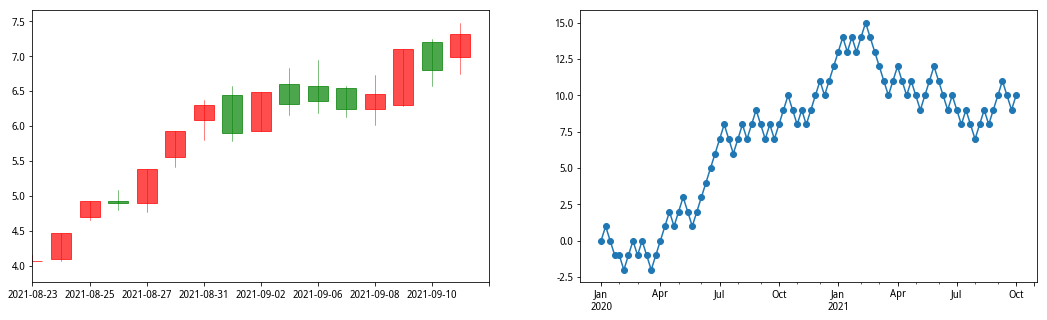

In [149]:
fig,axes = plt.subplots(1,2,figsize=(18,5))

sign1 = normalize.normalize_monotone()

price.plot.ochl(ax=axes[0])
sign1.plot(marker='o',ax=axes[1]);

## 基于5周期均线的标准化结构图

为了解决这个问题，一个自然而然的想法则是在对实际走势标准化过程 中，考虑趋势的方向这个维度，均线是对趋势方向一个比较好的量化指
标，因此我们引入 5 周期均线，那么状态变化向量定义为：

1. 如果当前收盘价大于或等于5周期均线价格，则为1；

2. 如果当前收盘价严格小于5周期均线价格，则为-1

实际用到了第一根K线之前的另外5根K线的收盘价数据。状态变化向量为（1，1，1，1，1，1，1，-1，-1，-1，-1），而位移向量为（0，1，2，3，4，5，6，7，6，5，4，3）。从基于5周期均线的标准化结构图可以看出，基本上反映了实际走势图的趋势状态，左侧呈现单边上扬而右侧单边下跌，但较实际图形趋势更强，这就是5周期均线定义的美中不足之处，过于强化了趋势，而淡化了实际价格在均线之上或之下的涨跌波动变化，换言之，趋势粉饰过多，而震荡考量不足。

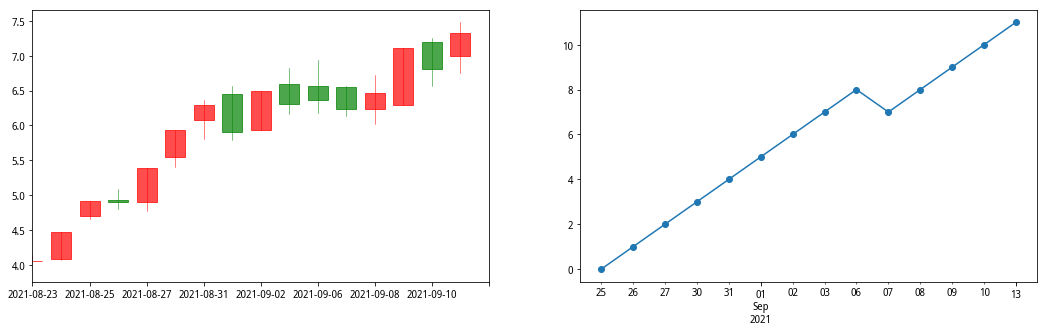

In [51]:
fig,axes = plt.subplots(1,2,figsize=(18,5))

sign2 = normalize.normalize_movingaverage(5)

price.plot.ochl(ax=axes[0])
sign2.plot(marker='o',ax=axes[1]);

## 融合收盘价单调性和5周期均线的标准化结构图

实际走势的标准化过程既要考虑到价格的震荡又要兼顾到趋势的状态，相比较前面两个简化方法，一个比较好的方法是融合收盘价单调性和5周期均线两个维度来标准化实际K线走势图。

1. 前一个交易日收盘价位于均线之下，当前收盘价站上均线，状态记为1；

2. 前一个交易日收盘价位于均线之上，当前收盘价跌破均线，状态记为-1；

3. 3a) 前一个交易日收盘价位于均线之上，当前收盘价位于均线之上，当前收盘价大于或等于前一个交易日收盘价，状态记为1，3b) 前一个交易日收盘价位于均线之上，当前收盘价位于均线之上，当前收盘价小于前一个交易日收盘价，状态记为0；

4. 4a) 前一个交易日收盘价位于均线之下，当前收盘价位于均线之下，当前收盘价大于前一个交易日收盘价，状态记为0，4b) 前一个交易日收盘价位于均线之下，当前收盘价位于均线之下，当前收盘价小于或等于前一个交易日收盘价，状态记为-1。

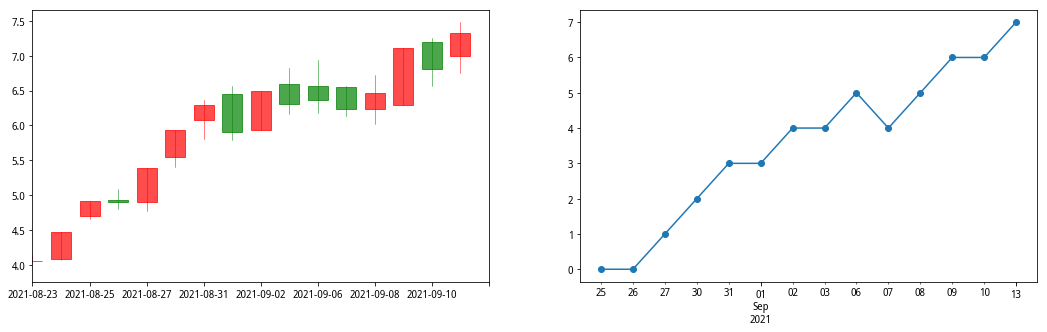

In [52]:
fig,axes = plt.subplots(1,2,figsize=(18,5))

sign3 = normalize.normalize_compound(5)

price.plot.ochl(ax=axes[0])
sign3.plot(marker='o',ax=axes[1]);

# 势的定义之一：基于连续波段定义

有了实际走势的标准化结构图，就可以进一步探讨如何设计“势”。如前所述，趋势的“势”既然用来刻画价格走势的“趋”的程度，那么价 格越单边上扬或下行，势应该越大；反之，越横盘震荡，势应该越小。 换言之，在同样的时间窗口内，价格波段越是起伏转折，势就越小，反之，单边涨跌波段越有持续性，势就越大。所以，势的定义可以从连续 波段入手，首先把上涨、下跌的波段一段段分割开。如下图，红色标注 的点为拐点，每两个拐点之间为一个连续涨跌波段，此处的拐点即是原上涨或下跌改变方向的节点。

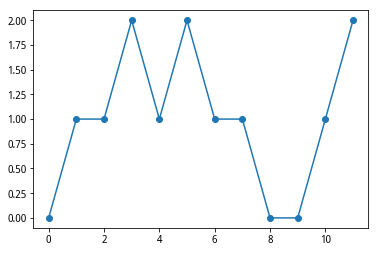

In [53]:
test_value = [0,1,1,2,1,2,1,1,0,0,1,2]
test_ser = pd.Series(data=test_value,index=range(len(test_value)))

test_ser.plot(marker='o');

$(趋,势) = \left(\sum^{k}_{i=1}d_i,\sum^{k}_{i=1}d^2_i)\right)$

In [54]:
test_arr = np.array([[0,0,0],
                     [1,1,1],
                     [2,2,2],
                     [3,3,3],
                     [4,4,4],
                     [5,5,5],
                     [6,6,4],
                     [7,7,5],
                     [8,6,6],
                     [9,7,7],
                     [8,8,8]])

df1 = pd.DataFrame(test_arr,columns='A,B,C'.split(','))

举例看下图三种走势，趋向都为上涨，上涨位移8步。从趋势定义可知， 第一个走势的“势”最大为 82，第二个走势次之为 54，第三个走势最小为 42。第一种走势“势”最大原因是连续出现9步上涨，而第二个走势出现了连续7步上涨，第三个走势出现了连续5步。所以综合来看，三种走势具有相同的“趋”，但“势”不同。

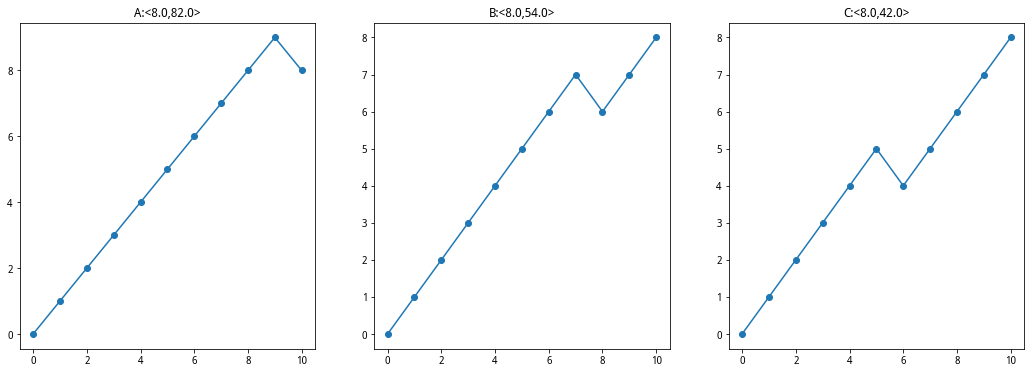

In [64]:
def get_act_trend_score(ser: pd.Series) -> Tuple:

    trend_score = Tren_Score(ser)
    trend_score.calc_trend_score('opposite')

    return (trend_score.score['opposite'].act_score,
            trend_score.score['opposite'].trend_score)

test_arr = np.array([[0,0,0],
                     [1,1,1],
                     [2,2,2],
                     [3,3,3],
                     [4,4,4],
                     [5,5,5],
                     [6,6,4],
                     [7,7,5],
                     [8,6,6],
                     [9,7,7],
                     [8,8,8]])

df1 = pd.DataFrame(test_arr,columns='A,B,C'.split(','))

# df1.plot(subplots=True,layout=(1,3),marker='o');
score_df1 = df1.apply(lambda x:get_act_trend_score(x)).T

fif,axes = plt.subplots(1,3,figsize=(18,6))

for ax,(col_name,score_ser),(_,ser_v) in zip(axes,score_df1.T.items(),df1.items()):
    
    a,b = score_ser # 趋,势
    ser_v.plot(ax=ax,marker='o',title=f'{col_name}:<{a},{b}>')

# 势的定义之二：基于绝对波动区间的势

上述势的定义仍然存在不尽如人意的地方，举例来看，如下图，在相同 的时间长度（都为 10 步），三种走势的趋是相等的，都为 6，但根据上 述定义可知势是不同的，第一种走势的势为 32，大于第二种走势的 26， 大于第三种走势的 24。之所以出现这种差异化，在于势的定义对价格在 同一方向连续性变化赋予了极高的二次方权重。但实际上，从价格走势的观察而言，我们其实认为这三种走势的势没有差别，应该是相同的。

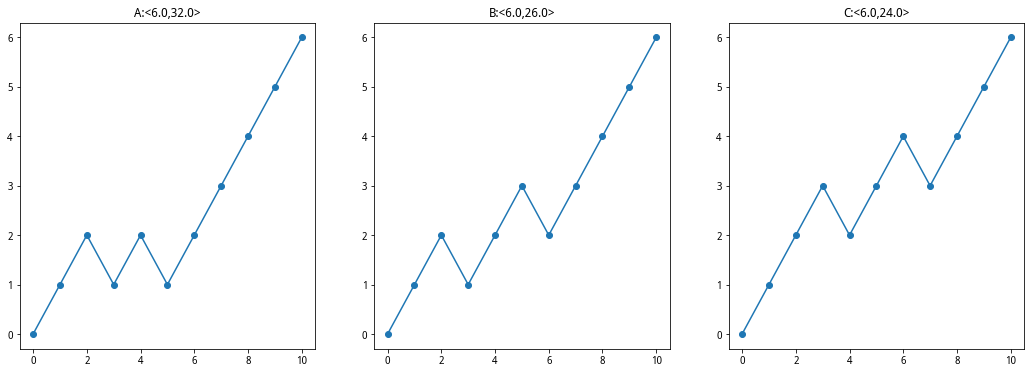

In [65]:
test_arr1 = np.array([[0,0,0],
                     [1,1,1],
                     [2,2,2],
                     [1,1,3],
                     [2,2,2],
                     [1,3,3],
                     [2,2,4],
                     [3,3,3],
                     [4,4,4],
                     [5,5,5],
                     [6,6,6]])

df2 = pd.DataFrame(test_arr1,columns='A,B,C'.split(','))

#df2.plot(subplots=True,layout=(1,3),marker='o')

score_df2 = df2.apply(lambda x:get_act_trend_score(x)).T


fif,axes = plt.subplots(1,3,figsize=(18,6))

for ax,(col_name,score_ser),(_,ser_v) in zip(axes,score_df2.T.items(),df2.items()):
    
    a,b = score_ser # 趋,势
    ser_v.plot(ax=ax,marker='o',title=f'{col_name}:<{a},{b}>')

为了实现经验观察与数量计算相吻合，需要进一步构建趋势指标。从上 面三幅走势图可以看出，相同时间窗口价格走势的绝对波动区间是一个 重要因素，简而言之，在相同的时间维度下，价格的波动区间越大，趋 势的势越大，价格的波动区间越小，趋势的势也越小，这基本上符合我们对上述此类图形的认知。

基于绝对波动区间的势定义，本质上先找到走势图上最高点和最低点， 然后把连接最低点到最高点之间的波段移出，之后对剩下的走势（也许 是一部分，也许是两部分）继续寻找最高点和最低点，重复上述步骤，实际上是一个递归过程，然后把所有移出波段的位移求平方和。

严谨的基于绝对波动区间定义的数学描述如下。假定价格状态向量如 下，（ 1 1 0 1 -1 0 -1 1 1 -1 0 0 1 1 1 1 -1 -1 -1 ），可以用变量记为$(\delta_1,\delta_2,\delta_3,\dots,\delta_n)$,那么价格位移定义为:$s_k=s_0+\sum^k_{i=1}\delta_i,k=1,2,3,\dots,n,s_0=0$

定义二元数组集合，满足价格波动区间最大值，换言之，寻找时间窗口内价格最大值和最小值。

$\Gamma=\lbrace(x,y)|x,y\in{0,1,2,\dots,n};x<y;|S_{x}-S_{y}| = \underset{max}{1<j,k\leq n}|S_{j}-S_{k}|\rbrace$

定义最短距离集合：

$\Omega=\lbrace(\alpha,\beta)\in{\Gamma}:|\alpha-\beta| = \underset{min}{(x,y)\in{\Gamma}}|x-y|\rbrace$

In [66]:
test_arr2 = np.array([1,1,0,1,-1,0,-1,1,1,-1,0,0,1,1,1,1,-1,-1,-1])

ser = pd.Series(test_arr2)

cum_ser = ser.cumsum() 

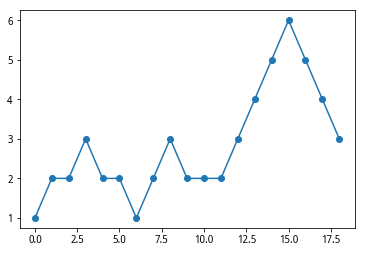

In [67]:
cum_ser.plot(marker='o');

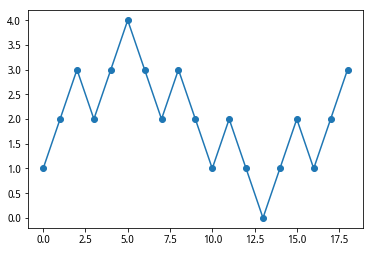

In [68]:
test_arr3 = np.array([1,2,3,2,3,4,3,2,3,2,1,2,1,0,1,2,1,2,3])
ser = pd.Series(test_arr3)

ser.plot(marker='o');

# 势的终极定义：基于绝对波动区间与连续波段的势

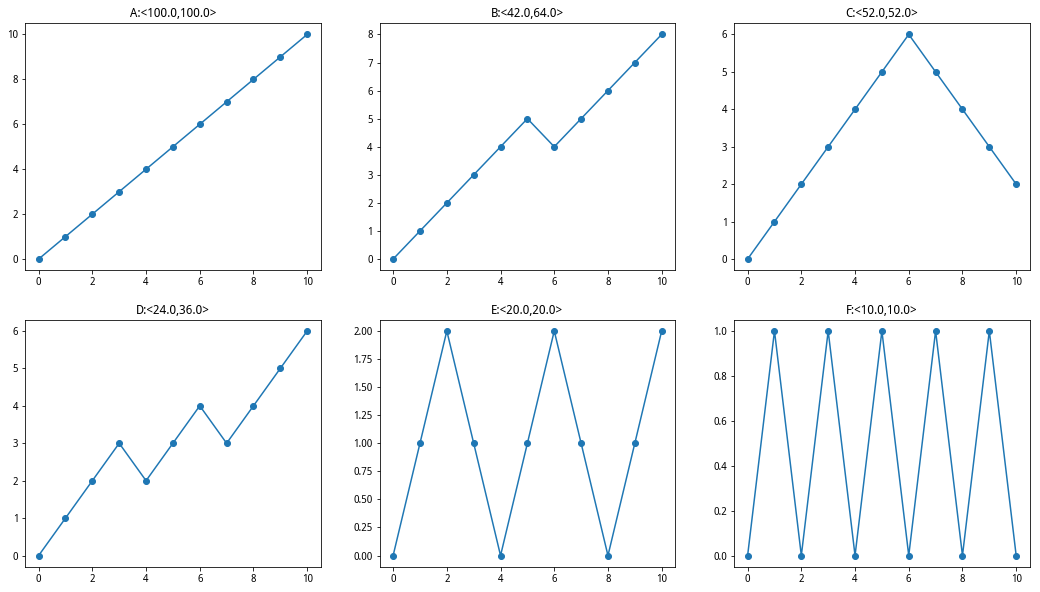

In [69]:
def compare_score(ser: pd.Series) -> Tuple:

    trend_score = Tren_Score(ser)

    trend_score.calc_trend_score(
        'opposite')

    

    trend_score.calc_trend_score(
        'absolute')

    opposit_trend_score = trend_score.score['opposite'].trend_score
    absolute_trend_score = trend_score.score['absolute'].trend_score
    return opposit_trend_score, absolute_trend_score
    
test_arr4 = np.array([[0, 0, 0, 0, 0, 0],
                     [1, 1, 1, 1, 1, 1],
                     [2, 2, 2, 2, 2, 0],
                     [3, 3, 3, 3, 1, 1],
                     [4, 4, 4, 2, 0, 0],
                     [5, 5, 5, 3, 1, 1],
                     [6, 4, 6, 4, 2, 0],
                     [7, 5, 5, 3, 1, 1],
                     [8, 6, 4, 4, 0, 0],
                     [9, 7, 3, 5, 1, 1],
                     [10, 8, 2, 6, 2, 0]])

df4 = pd.DataFrame(test_arr4,columns='A,B,C,D,E,F'.split(','))

score_df3 = df4.apply(compare_score)

score_df3 = score_df3.T

fif,axes = plt.subplots(2,3,figsize=(18,10))

for ax,(col_name,score_ser),(_,ser_v) in zip(np.ravel(axes),score_df3.T.items(),df4.items()):
    
    a,b = score_ser
    ser_v.plot(ax=ax,marker='o',title=f'{col_name}:<{a},{b}>')


合理的势定义应该是连续波段定义的势与绝对波动区间 的势取二者较大的值

势 = $max\left(\sum^{m}_{i=1}(S_{\alpha_i}-S_{\beta_i}),\sum^{k}_{i=1}d^2_i\right)$

# 不同长度的时间序列的势构建

$T = max\lbrace\sum^{m}_{i=1}(S_{\alpha_{i}}-S_{\beta_{i}})^2,\sum^k_{i=1}d^2_i\rbrace/N^{\frac{3}{2}}$

# 对量化趋势得分进行应用

## 检查不同行情下得分段情况

In [124]:
hs300 = get_price('000300.XSHG', start_date='2014-01-01',
                  end_date='2021-10-25', fields=['close','open','high','low'], panel=False)

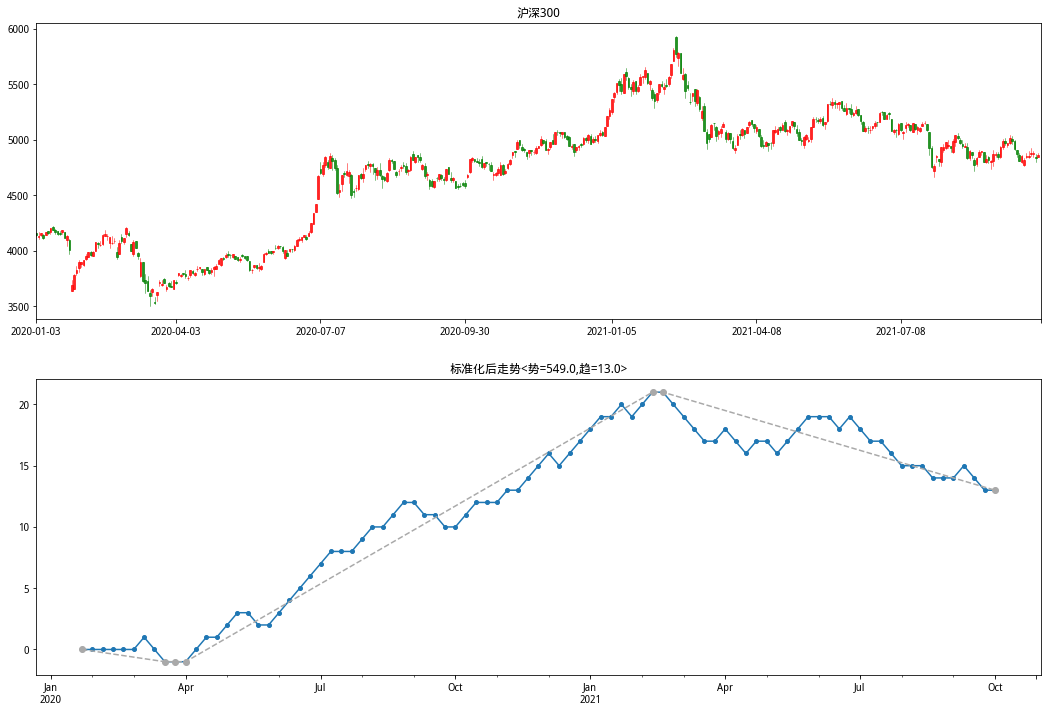

In [156]:
slice_price = hs300.loc['2020-01-01':'2021-10-01','close']

weekly_bar = slice_price.resample('W').last()

normalize = Normalize_Trend(weekly_bar)
normalize_trend_ser = normalize.normalize_compound(5)

trend_score = Tren_Score(normalize_trend_ser)
trend_score.calc_trend_score('absolute')

fig, axes = plt.subplots(2, figsize=(18, 12))

hs300.loc['2020-01-01':'2021-10-01'].plot.ochl(ax=axes[0],title='沪深300')

a = trend_score.score['absolute'].trend_score
b = trend_score.score['absolute'].act_score

axes[1].set_title(f'标准化后走势<势={a},趋={b}>')
normalize_trend_ser.plot(ax=axes[1], marker='o',ms=4)
trend_score.point_frame['absolute'].plot(
    ax=axes[1], marker='o', ls='--', color='darkgray');

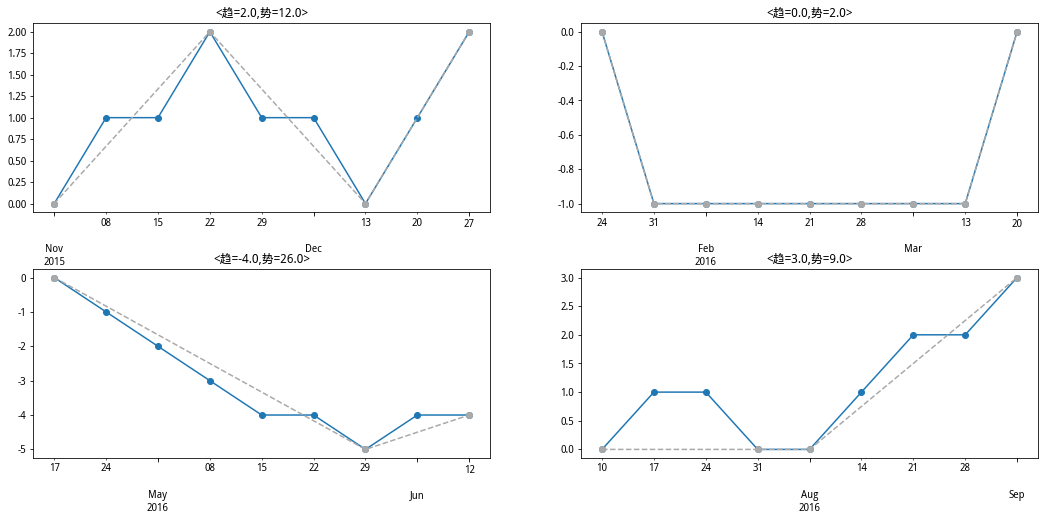

In [163]:
point_list = []
normalize_trend_list = []
score = []
for i in range(12, len(weekly_bar), 12):

    normalize = Normalize_Trend(weekly_bar.iloc[i-12:i])
    normalize_trend_ser = normalize.normalize_compound(5)

    trend_score = Tren_Score(normalize_trend_ser)
    normalize_trend_list.append(normalize_trend_ser)

    trend_score.calc_trend_score('absolute')
    score.append((trend_score.score['absolute'].act_score,
                 trend_score.score['absolute'].trend_score))
    point_list.append(trend_score.point_frame['absolute'])

fig, axes = plt.subplots(2, 2, figsize=(18, 4 * 2))

for ax, ser1, ser2, score in zip(np.ravel(axes), normalize_trend_list, point_list,score):
    
    a,b =score
    ser1.plot(ax=ax, marker='o',title=f'<趋={a},势={b}>')
    ser2.plot(ax=ax, marker='o', ls='--', color='darkgray')
    
plt.subplots_adjust(hspace=0.3);

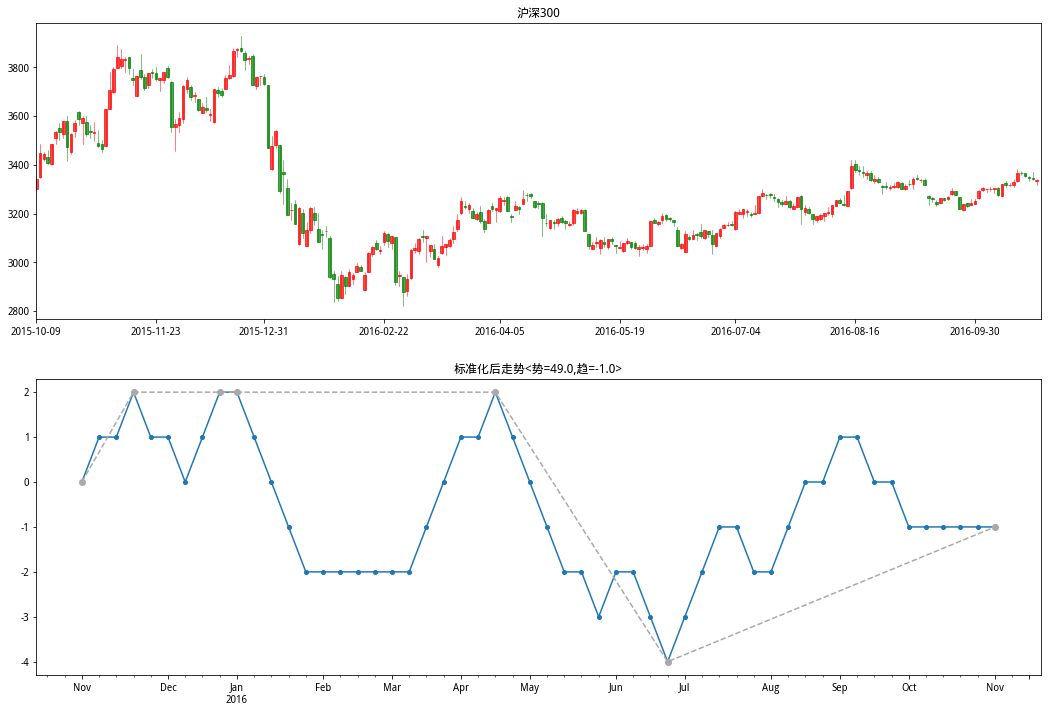

In [160]:
slice_price = hs300.loc['2015-10-01':'2016-10-31', 'close']
weekly_bar = slice_price.resample('W').last()

normalize = Normalize_Trend(weekly_bar)
normalize_trend_ser = normalize.normalize_compound(5)

trend_score = Tren_Score(normalize_trend_ser)
normalize_trend_list.append(normalize_trend_ser)

trend_score.calc_trend_score('absolute')
a = trend_score.score['absolute'].trend_score
b = trend_score.score['absolute'].act_score

fig, axes = plt.subplots(2, figsize=(18, 12))

hs300.loc['2015-10-01':'2016-10-31'].plot.ochl(ax=axes[0],title='沪深300')
axes[1].set_title(f'标准化后走势<势={a},趋={b}>')
normalize_trend_ser.plot(ax=axes[1], marker='o',ms=4)
trend_score.point_frame['absolute'].plot(
    ax=axes[1], marker='o', ls='--', color='darkgray');

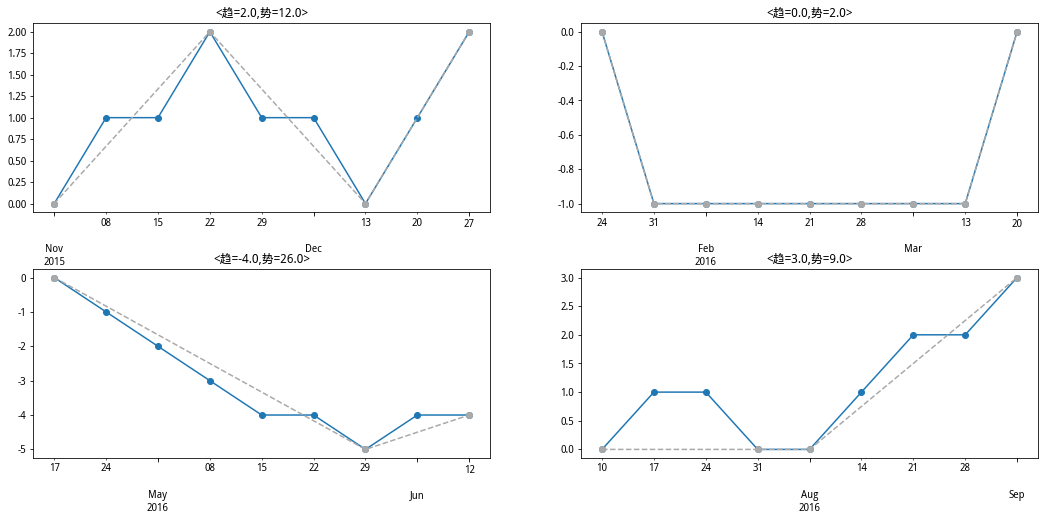

In [164]:
point_list = []
normalize_trend_list = []
score = []
for i in range(12, len(weekly_bar), 12):

    normalize = Normalize_Trend(weekly_bar.iloc[i-12:i])
    normalize_trend_ser = normalize.normalize_compound(5)

    trend_score = Tren_Score(normalize_trend_ser)
    normalize_trend_list.append(normalize_trend_ser)

    trend_score.calc_trend_score('absolute')
    score.append((trend_score.score['absolute'].act_score,
             trend_score.score['absolute'].trend_score))
    point_list.append(trend_score.point_frame['absolute'])

fig, axes = plt.subplots(2, 2, figsize=(18, 4 * 2))

for ax, ser1, ser2, score in zip(np.ravel(axes), normalize_trend_list, point_list,score):
    
    a,b =score
    ser1.plot(ax=ax, marker='o',title=f'<趋={a},势={b}>')
    ser2.plot(ax=ax, marker='o', ls='--', color='darkgray')
    
plt.subplots_adjust(hspace=0.3);

## 构造信号用于回测

In [75]:
def calc_trend_score(ser:pd.Series)->float:
    
    # 转为周度
    #ser = ser.resample('W').last().copy() 

    normalize = Normalize_Trend(ser)

    # 此时是周级别得均线
    normalize_trend_ser = normalize.normalize_compound(5)

    trend_score = Tren_Score(normalize_trend_ser)

    trend_score.calc_trend_score('absolute')

    return trend_score.score['absolute'].trend_score

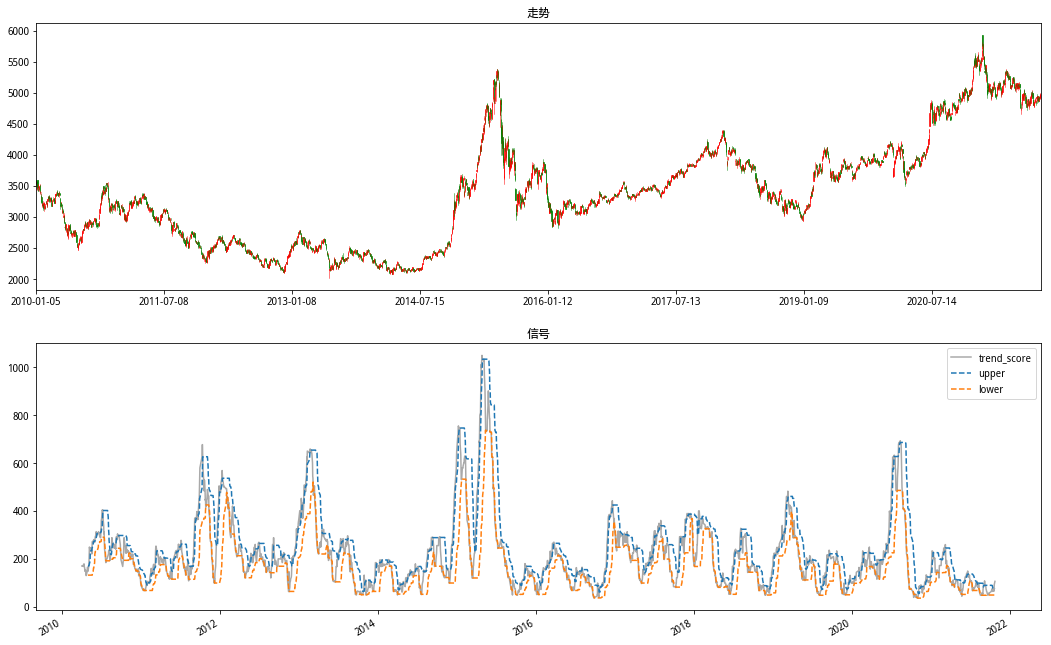

In [98]:
score = hs300['close'].rolling(60).apply(calc_trend_score,raw=False)
lower_bound = score.rolling(20).apply(lambda x: x.quantile(0.05),raw=False)
upper_bound = score.rolling(20).apply(lambda x: x.quantile(0.85),raw=False)

fig, axes = plt.subplots(2, 1, figsize=(18, 12))

hs300.plot.ochl(ax=axes[0],title='走势')

axes[1].set_title('信号')
score.plot(ax=axes[1], color='darkgray', label='trend_score')
upper_bound.plot(ax=axes[1], ls='--', label='upper')
lower_bound.plot(ax=axes[1], ls='--', label='lower')

plt.legend();

大于上轨开仓至信号上传下轨平仓

In [99]:
def get_hold_flag(df:pd.DataFrame)->pd.Series:
    '''
    标记持仓
    ------
    输入参数：
        df:index-date columns-score|lower_bound|upper_bound
    ------
    return index-date 1-持仓;0-空仓
    '''
    flag = pd.Series(index=df.index,data=np.zeros(len(df)))

    for trade,row in df.iterrows():
        
        sign = row['score']
        lower = row['lower_bound']
        upper = row['upper_bound']
        try:
            previous_score
        except NameError:
            previous_score = sign
            previous_lower = lower
            previous_upper = upper
            order_flag = 0
            continue
        
        if previous_score > previous_lower and sign <= lower:
        
            flag[trade] = 0
            order_flag = 0
            
        elif previous_score < previous_upper and sign >= upper:
            flag[trade] = 1
            order_flag = 1

        else:
            
            flag[trade] = order_flag
        
        previous_score = sign
        previous_lower = lower
        previous_upper = upper
            
    return flag

In [100]:
df = pd.concat((score,upper_bound,lower_bound),axis=1)
df.columns = ['score','upper_bound','lower_bound']

flag = get_hold_flag(df)
next_ret = hs300['close'].pct_change().shift(-1)

algorithms_ret = flag * next_ret.loc[flag.index]

algorithms_cum = ep.cum_returns(algorithms_ret)

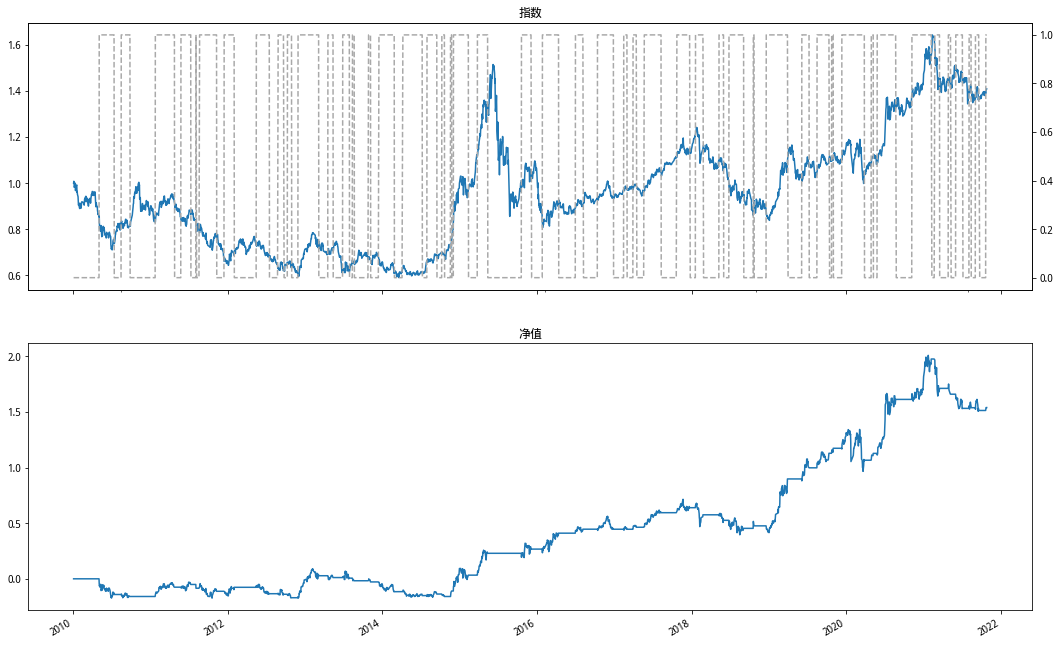

In [101]:
fig,axes = plt.subplots(2,figsize=(18,12))

axes[0].set_title('指数')
(hs300['close']/hs300['close'][0]).plot(ax=axes[0])
axes[1].set_title('净值')
flag.plot(ax=axes[0],secondary_y=True,ls='--',color='darkgray')
algorithms_cum.plot(ax=axes[1]);